In [2]:
import os, sys
import shutil
import time
import numpy as np
import pandas as pd

import torch

# Matplotlib for additional customization
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
for p in ['../spotlight_ext']:
    module_path = os.path.abspath(os.path.join(p))
    if module_path not in sys.path:
        sys.path.append(module_path)

random_state = np.random.RandomState(2020)

In [4]:
from spotlight.cross_validation import random_train_test_split
from spotlight.datasets.movielens import get_movielens_dataset

# get dataset
dataset = get_movielens_dataset(variant='1M')
train, test = random_train_test_split(dataset, random_state=random_state)

max_sequence_length = 20
train = train.to_sequence(max_sequence_length=max_sequence_length)
test = test.to_sequence(max_sequence_length=max_sequence_length)

In [5]:
%run helpers.ipynb

In [ ]:
non_solvable_cases = []
total_data = []

for items in best_cfs:
    for idx, rec in enumerate(items):
        if rec is None: continue

        if not rec.solution_found: 
            non_solvable_cases.append(rec.user_id)
            continue

        similarities = blnet.forward(torch.LongTensor([rec.user_id]),torch.LongTensor([0, 3]))
        similarity_rank = len(rec.complete_interactions) - st.rankdata(similarity_matrix[rec.item_id, rec.complete_interactions]) + 1
        del_items_indices = np.where(np.isin(rec.complete_interactions, list(set(rec.complete_interactions).difference(set(rec.interactions)))))
#         total_data.extend(list(similarity_rank[del_items_indices].astype(int)))

        total_data.append([
            rec.user_id, idx, rec.item_id, rec.y_loss, rec.proximity_loss, 
            ','.join(map(str, sorted(similarity_rank[del_items_indices].astype(int)))),
            ','.join(map(str, set(rec.complete_interactions).difference(set(rec.interactions)))),
        ])

In [31]:
blnet = BilinearNet(max(test.user_ids) + 1, test.num_items)
blnet.forward(torch.LongTensor([0]),torch.LongTensor([0, 3]))

tensor([0.0006, 0.0033], grad_fn=<AddBackward0>)

# Train Implicit model

In [4]:
from spotlight.factorization.representations import BilinearNet
from spotlight.factorization.implicit import ImplicitFactorizationModel


CUDA = (os.environ.get('CUDA') is not None or
        shutil.which('nvidia-smi') is not None)

train, rest = random_train_test_split(
    dataset,
    test_percentage=0.2,
    random_state=random_state)
test, validation = random_train_test_split(
    rest,
    test_percentage=0.5,
    random_state=random_state)

blnet = BilinearNet(max(test.user_ids) + 1, test.num_items)
implicit_model = ImplicitFactorizationModel(
    loss='adaptive_hinge',
    n_iter=10,
    batch_size=32,
    learning_rate=1e-3,
    embedding_dim=256,
    l2=0.0,
    representation=blnet,
    use_cuda=CUDA,
    random_state=np.random.RandomState(2020))

start_time = time.time()
implicit_model.fit(train, verbose=True)
elapsed = time.time() - start_time

print('Elapsed {}'.format(elapsed))
print(implicit_model)

# (test_mrr, val_mrr, elapsed) = evaluate_model(
#     model,
#     train,
#     test,
#     validation)

# print('Test MRR {} val MRR {} elapsed {}'.format(
#     test_mrr.mean(), val_mrr.mean(), elapsed
# ))

Epoch 0: loss 0.9350682098317469
Epoch 1: loss 0.8305614869015165
Epoch 2: loss 0.7903238802058958
Epoch 3: loss 0.7702323526124959
Epoch 4: loss 0.7567163172194283
Epoch 5: loss 0.7494972313889158
Epoch 6: loss 0.7421358088681691
Epoch 7: loss 0.7387003473038293
Epoch 8: loss 0.7344479968807539
Epoch 9: loss 0.7313618868110295
Elapsed 321.6028838157654
<ImplicitFactorizationModel: BilinearNet(
  (user_embeddings): ScaledEmbedding(6041, 32)
  (item_embeddings): ScaledEmbedding(3707, 32)
  (user_biases): ZeroEmbedding(6041, 1)
  (item_biases): ZeroEmbedding(3707, 1)
)>


In [44]:
save_model(implicit_model, model_type='implicit_factorization')

In [62]:
# running example
implicit_model._net.item_embeddings(torch.LongTensor([1]))

tensor([[ 0.1438,  0.1725,  0.0882, -0.2568,  0.4821,  0.3086,  0.1152,  0.0791,
         -0.1067,  0.0675,  0.3092, -0.0680,  0.0643, -0.5746, -0.4260, -0.6820,
          0.1860, -0.3599,  0.3382, -0.5775,  0.2283, -0.1712, -0.4755, -0.2974,
         -0.0607, -0.0758,  0.1443, -0.0623,  0.2852,  0.2158, -0.0940, -0.3759]],
       grad_fn=<EmbeddingBackward>)

### load appropriate models

In [60]:
# implicit_model = load_model('implicit_factorization')
lstm_model = load_model(model_type='entire')
pooling_model = load_model('pooling')

## Use embeddings from **MatrixFactorization** model to compute item similarities on **LSTM-based** model recommendations

In [50]:
implicit_sims_matrix = gpu_embeddings_to_cosine_similarity_matrix(
    implicit_model._net.item_embeddings(
        torch.arange(0, test.num_items, dtype=torch.int64)
    ))

In [61]:
best_cfs, _ = find_cfs(test, lstm_model, 7, no_users=500)

In [63]:
cnt, non_solvable = rank_interactions_to_excluded_item_per_user(best_cfs, implicit_sims_matrix.detach().numpy())

Text(0.5, 0.98, 'Counting the worst similarity position of each discovered counterfactual')

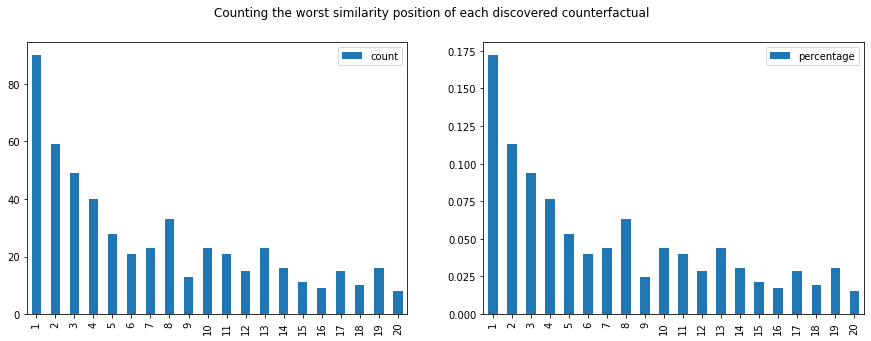

In [66]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))

df = pd.DataFrame.from_dict(cnt, orient='index', columns=['count'])
df['percentage'] = df/df.sum()
df.sort_index().plot.bar(y='count', ax=axs[0])
df.sort_index().plot.bar(y='percentage', ax=axs[1])

plt.suptitle('Counting the worst similarity position of each discovered counterfactual')

In [67]:
from collections import Counter


non_solvable_cases = []
total_data = []
for items in best_cfs:
    for rec in items:
        if rec is None: continue
            
        if not rec.solution_found: 
            non_solvable_cases.append(rec.user_id)
            continue

        total_data.append(rec.proximity_loss)
    
cnt = Counter(total_data)

Text(0.5, 0.98, 'No of items to exclude from interacted list to have the recommendations change accordingly')

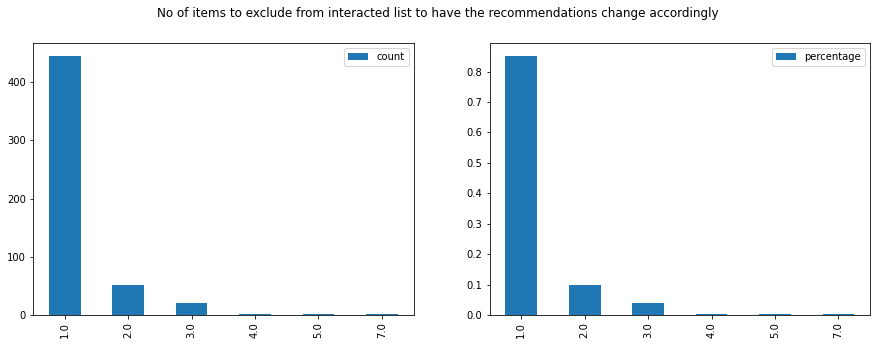

In [68]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))

df = pd.DataFrame.from_dict(cnt, orient='index', columns=['count'])
df['percentage'] = df/df.sum()
df.sort_index().plot.bar(y='count', ax=axs[0])
df.sort_index().plot.bar(y='percentage', ax=axs[1])

plt.suptitle('No of items to exclude from interacted list to have the recommendations change accordingly')

## Use embeddings from **MatrixFactorization** model to compute item similarities on **Pooling-based** model recommendations

In [69]:
implicit_sims_matrix = gpu_embeddings_to_cosine_similarity_matrix(
    implicit_model._net.item_embeddings(
        torch.arange(0, test.num_items, dtype=torch.int64)
    ))

In [70]:
best_cfs, _ = find_cfs(test, pooling_model, 7, no_users=500)

In [71]:
cnt, non_solvable = rank_interactions_to_excluded_item_per_user(best_cfs, implicit_sims_matrix.detach().numpy())

Text(0.5, 0.98, 'Counting the worst similarity position of each discovered counterfactual')

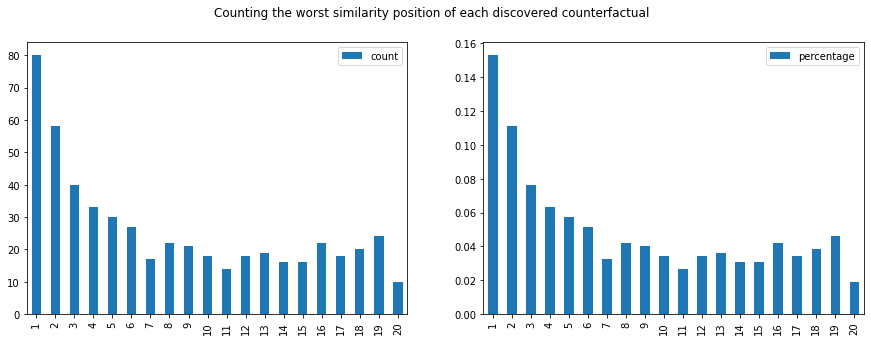

In [72]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))

df = pd.DataFrame.from_dict(cnt, orient='index', columns=['count'])
df['percentage'] = df/df.sum()
df.sort_index().plot.bar(y='count', ax=axs[0])
df.sort_index().plot.bar(y='percentage', ax=axs[1])

plt.suptitle('Counting the worst similarity position of each discovered counterfactual')

In [73]:
from collections import Counter


non_solvable_cases = []
total_data = []
for items in best_cfs:
    for rec in items:
        if rec is None: continue
            
        if not rec.solution_found: 
            non_solvable_cases.append(rec.user_id)
            continue

        total_data.append(rec.proximity_loss)
    
cnt = Counter(total_data)

Text(0.5, 0.98, 'No of items to exclude from interacted list to have the recommendations change accordingly')

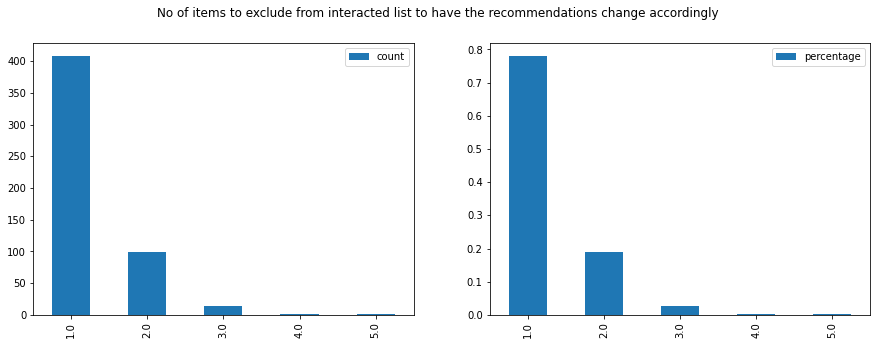

In [74]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))

df = pd.DataFrame.from_dict(cnt, orient='index', columns=['count'])
df['percentage'] = df/df.sum()
df.sort_index().plot.bar(y='count', ax=axs[0])
df.sort_index().plot.bar(y='percentage', ax=axs[1])

plt.suptitle('No of items to exclude from interacted list to have the recommendations change accordingly')